![logo](https://github.com/heberrossi/Curso_CientistaDeDados_EBAC_Exercicios/blob/main/logo/ebac_logo-data_science.png?raw=true)


# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?"

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          |
|------------------------|:-------------------|
|Administrative          | Quantidade de acessos em páginas administrativas|
|Administrative_Duration | Tempo de acesso em páginas administrativas |
|Informational           | Quantidade de acessos em páginas informativas  |
|Informational_Duration  | Tempo de acesso em páginas informativas  |
|ProductRelated          | Quantidade de acessos em páginas de produtos |
|ProductRelated_Duration | Tempo de acesso em páginas de produtos |
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  |
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações |
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico |
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) |
|Month                   | Mês  |
|OperatingSystems        | Sistema operacional do visitante |
|Browser                 | Browser do visitante |
|Region                  | Região |
|TrafficType             | Tipo de tráfego                  |
|VisitorType             | Tipo de visitante: novo ou recorrente |
|Weekend                 | Indica final de semana |
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
!pip install gower

In [2]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns

from gower import gower_matrix

from scipy.spatial.distance  import squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

In [3]:
df = pd.read_csv('online_shoppers_intention.csv')

In [4]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [6]:
# Imprimir informações sobre a estrutura do DataFrame
print(f'''
Quantidade de linhas: {df.shape[0]}
Quantidade de colunas: {df.shape[1]}

Quantidade de valores missing: {df.isna().sum().sum()}
''')

# incluindo os tipos de dados de cada coluna e a contagem de valores não nulos
df.info()


Quantidade de linhas: 12330
Quantidade de colunas: 18

Quantidade de valores missing: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null 

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [7]:
# Lista de variáveis que descrevem o padrão de navegação na sessão
padrão_de_navegação = ['Administrative',
                       'Administrative_Duration',
                       'Informational',
                       'Informational_Duration',
                       'ProductRelated',
                       'ProductRelated_Duration',
                       'PageValues',
                       'OperatingSystems',
                       'Browser',
                       'TrafficType',
                       'VisitorType']

In [8]:
# Lista de variáveis que indicam a característica da data
característica_da_data = ['SpecialDay', 'Month', 'Weekend']

In [9]:
# Selecionar as variáveis relacionadas ao padrão de navegação e à característica da data
df_ = df[padrão_de_navegação + característica_da_data]
df_.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,PageValues,OperatingSystems,Browser,TrafficType,VisitorType,SpecialDay,Month,Weekend
0,0,0.0,0,0.0,1,0.000000,0.0,1,1,1,Returning_Visitor,0.0,Feb,False
1,0,0.0,0,0.0,2,64.000000,0.0,2,2,2,Returning_Visitor,0.0,Feb,False
2,0,0.0,0,0.0,1,0.000000,0.0,4,1,3,Returning_Visitor,0.0,Feb,False
3,0,0.0,0,0.0,2,2.666667,0.0,3,2,4,Returning_Visitor,0.0,Feb,False
4,0,0.0,0,0.0,10,627.500000,0.0,3,3,4,Returning_Visitor,0.0,Feb,True


In [10]:
# Criando dummies das variáveis categóricas

df_dummies = pd.get_dummies(df_.dropna())
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12330 non-null  int64  
 1   Administrative_Duration        12330 non-null  float64
 2   Informational                  12330 non-null  int64  
 3   Informational_Duration         12330 non-null  float64
 4   ProductRelated                 12330 non-null  int64  
 5   ProductRelated_Duration        12330 non-null  float64
 6   PageValues                     12330 non-null  float64
 7   OperatingSystems               12330 non-null  int64  
 8   Browser                        12330 non-null  int64  
 9   TrafficType                    12330 non-null  int64  
 10  SpecialDay                     12330 non-null  float64
 11  Weekend                        12330 non-null  bool   
 12  VisitorType_New_Visitor        12330 non-null 

In [11]:
# Lista de variáveis numéricas
numerical = ['Administrative', 'Administrative_Duration','Informational',
             'Informational_Duration', 'ProductRelated',
             'ProductRelated_Duration', 'PageValues', 'SpecialDay']

# Selecionando apenas colunas categóricas
df_dummies_cat = df_dummies.drop(columns=numerical)
df_dummies_cat.head()

,OperatingSystems,Browser,TrafficType,Weekend,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,1,1,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False
1,2,2,2,False,False,False,True,False,False,True,False,False,False,False,False,False,False
2,4,1,3,False,False,False,True,False,False,True,False,False,False,False,False,False,False
3,3,2,4,False,False,False,True,False,False,True,False,False,False,False,False,False,False
4,3,3,4,True,False,False,True,False,False,True,False,False,False,False,False,False,False


In [12]:
# Lista de valores booleanos indicando se cada coluna é categórica
vars_cat = [True if x in df_dummies_cat else False for x in df_dummies.columns]

(df_dummies
 .dtypes
 .reset_index()
 .rename(columns={'index': 'Variável',
                  0: 'Tipo'})
 .assign(Categorical=vars_cat)
)

,Variável,Tipo,Categorical
0,Administrative,int64,False
1,Administrative_Duration,float64,False
2,Informational,int64,False
3,Informational_Duration,float64,False
4,ProductRelated,int64,False
5,ProductRelated_Duration,float64,False
6,PageValues,float64,False
7,OperatingSystems,int64,True
8,Browser,int64,True
9,TrafficType,int64,True


## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa.

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final.
- Se puder, sugira nomes para os grupos.

In [13]:
# Calculando as distâncias
distancia_gower = gower_matrix(df_dummies, cat_features=vars_cat)

In [14]:
gdv = squareform(distancia_gower,force='tovector')
gdv.shape

(76008285,)

In [15]:
Z = linkage(gdv, method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df.head()

,id1,id2,dist,n
0,64.0,140.0,0.0,2.0
1,143.0,12330.0,0.0,3.0
2,16.0,85.0,0.0,2.0
3,125.0,12332.0,0.0,3.0
4,158.0,12333.0,0.0,4.0


Leaves = 216


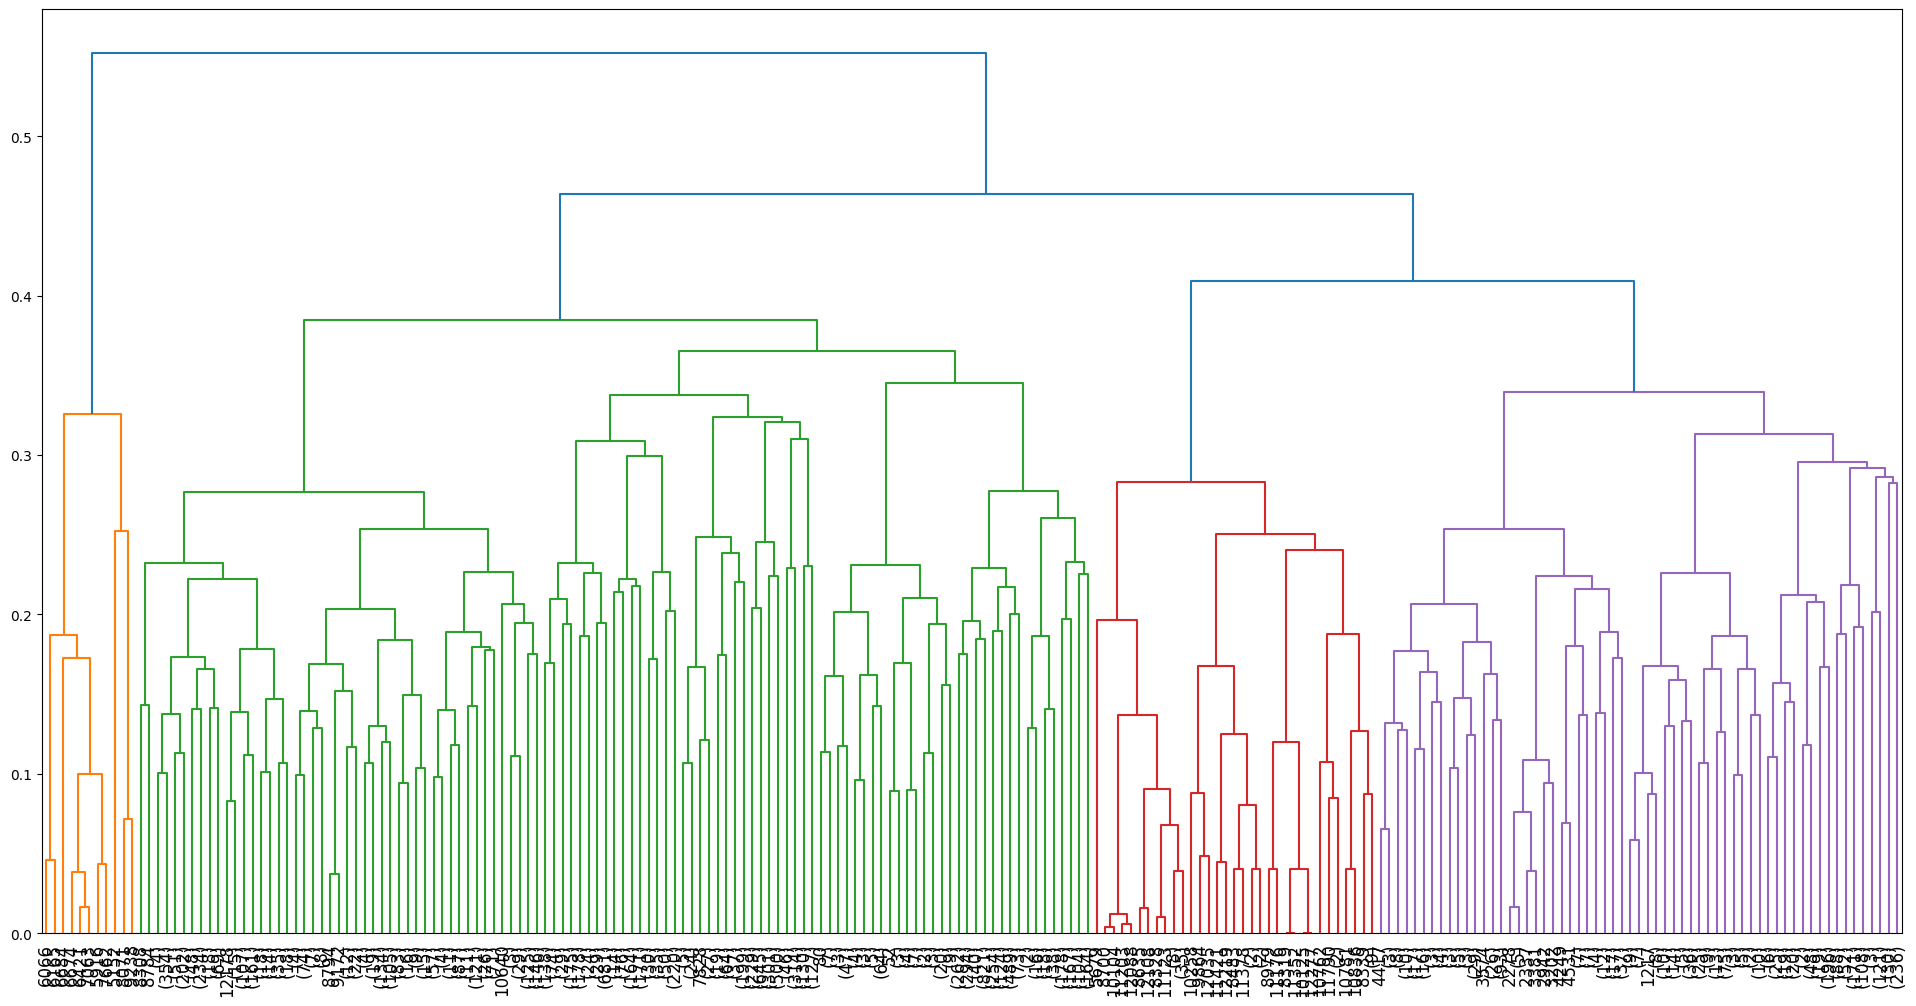

In [16]:
fig,axs = plt.subplots(1,1,figsize=(24,12))
dn = dendrogram(Z,
                truncate_mode='level',
                p=8,
                labels=df_dummies.index,
                leaf_rotation=90,
                leaf_font_size=12,
                show_contracted=True,
                show_leaf_counts=True,
                ax=axs,
                color_threshold=.39
                )

print(f"Leaves = {len(dn['leaves'])}")

Leaves = 216


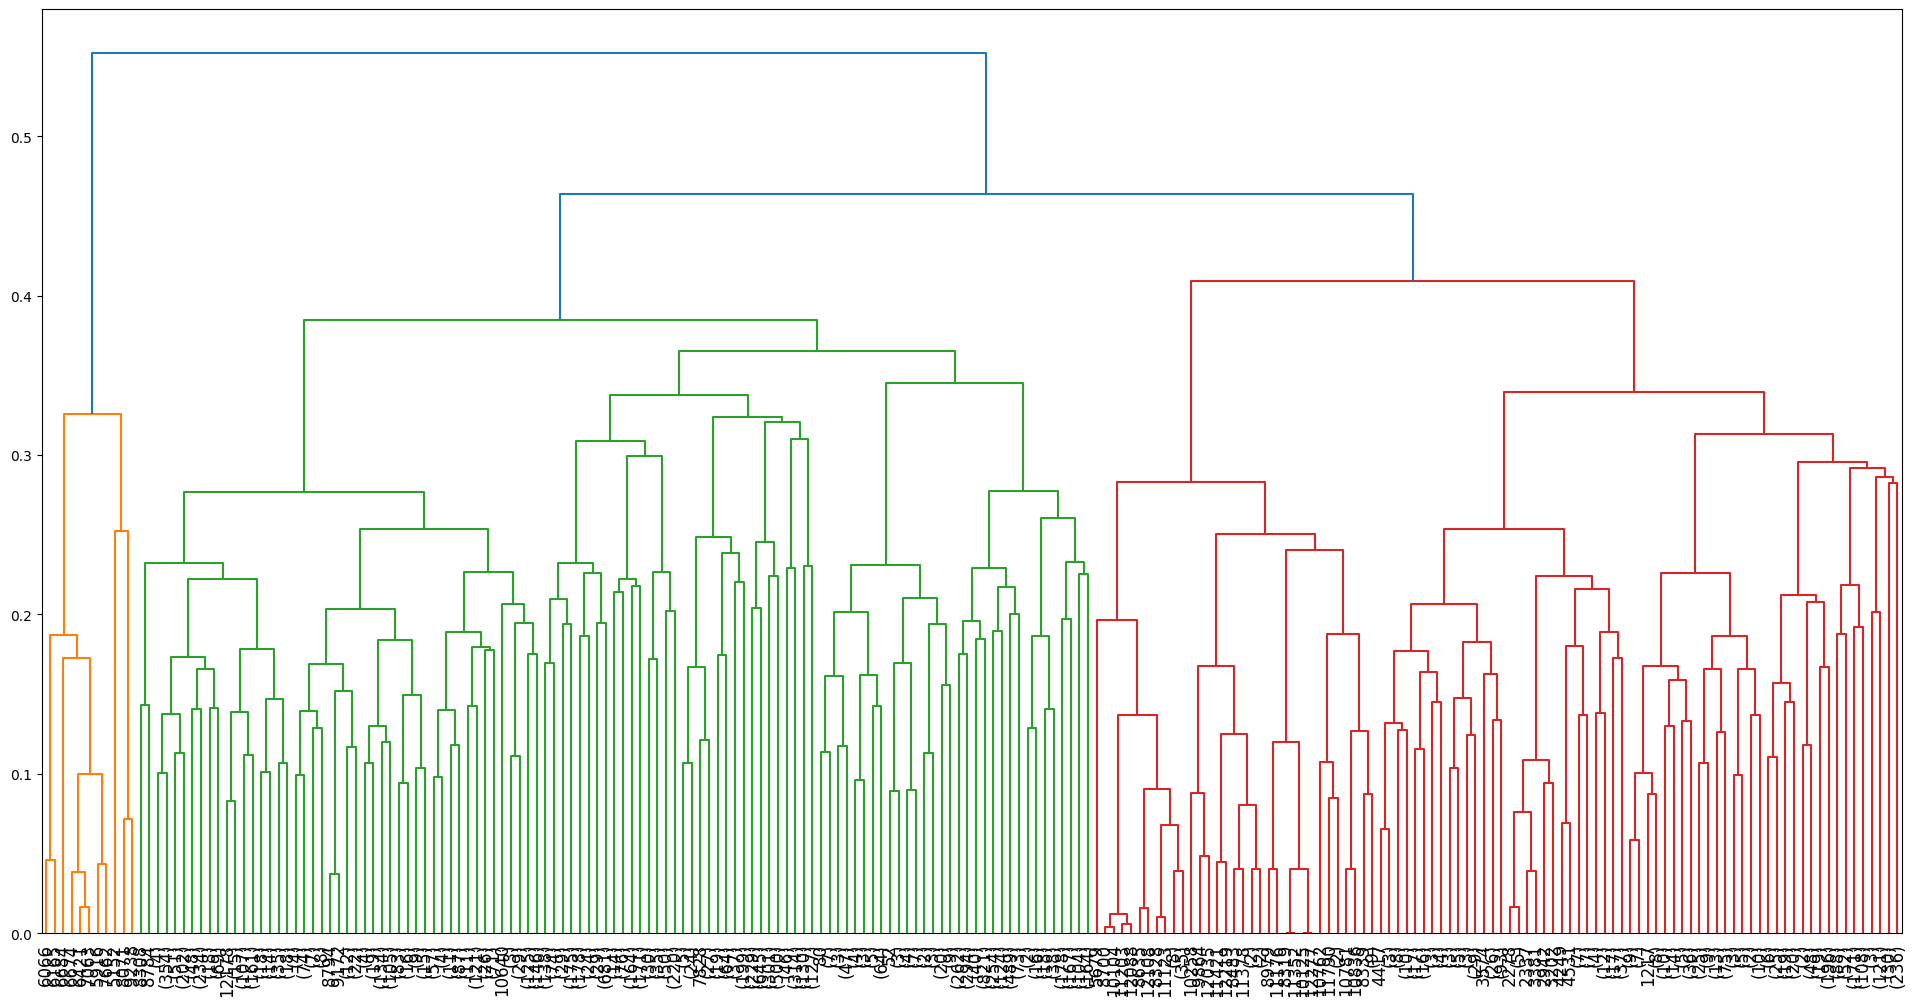

In [17]:
fig,axs = plt.subplots(1,1,figsize=(24,12))
dn = dendrogram(Z,
                truncate_mode='level',
                p=8,
                labels=df_dummies.index,
                leaf_rotation=90,
                leaf_font_size=12,
                show_contracted=True,
                show_leaf_counts=True,
                ax=axs,
                color_threshold=.42)

print(f"Leaves = {len(dn['leaves'])}")

In [18]:
df['grupo_4'] = fcluster(Z, 4, criterion='maxclust')
df_dummies['grupo_4'] = fcluster(Z, 4, criterion='maxclust')
df_dummies.grupo_4.value_counts()

grupo_4
2    10540
4     1694
3       85
1       11
Name: count, dtype: int64

In [19]:
# Criar e exibir uma tabela cruzada normalizada por linha para as variáveis 'VisitorType', 'grupo_5' e 'Revenue'
(pd.crosstab(index=df.VisitorType,
             columns=[df_dummies.grupo_4, df.Revenue],
             normalize='index')
 .applymap(lambda x: f'{x*100:.0f} %'))

grupo_4               1     2           3           4      
Revenue           False False True  False True  False True 
VisitorType                                                
New_Visitor         0 %   0 %   0 %   0 %   0 %  75 %  25 %
Other               0 %   0 %   0 %  81 %  19 %   0 %   0 %
Returning_Visitor   0 %  86 %  14 %   0 %   0 %   0 %   0 %

In [20]:
# Criar e exibir uma tabela cruzada normalizada por linha para as variáveis 'Revenue' e 'grupo_5',
(pd.crosstab(index=df.Revenue,
             columns=[df_dummies.grupo_4],
             normalize='index')
 .applymap(lambda x: f'{x*100:.0f} %'))

grupo_4,1,2,3,4
Revenue,,,,
False,0 %,87 %,1 %,12 %
True,0 %,77 %,1 %,22 %


In [21]:
# Criar e exibir uma tabela cruzada normalizada por coluna para as variáveis 'Month', 'grupo_5' e 'Revenue'
(pd.crosstab(index=df.Month,
             columns=[df_dummies.grupo_4, df.Revenue],
             normalize='columns')
 .applymap(lambda x: f'{x*100:.2f} %')
)

grupo_4        1        2                 3                 4         
Revenue    False    False    True     False    True     False    True 
Month                                                                 
Aug       9.09 %   3.36 %   3.74 %   0.00 %   0.00 %   4.01 %   4.98 %
Dec      18.18 %  13.23 %   8.71 %  71.01 %  81.25 %  20.44 %  17.77 %
Feb       0.00 %   1.98 %   0.20 %   0.00 %   0.00 %   0.08 %   0.00 %
Jul      18.18 %   3.54 %   3.74 %   0.00 %   0.00 %   3.38 %   2.61 %
June      0.00 %   2.59 %   1.50 %   1.45 %   0.00 %   1.81 %   1.66 %
Mar       0.00 %  16.75 %  10.61 %   0.00 %   0.00 %  15.41 %   8.53 %
May       9.09 %  30.51 %  18.84 %   0.00 %   0.00 %  18.16 %  20.85 %
Nov       0.00 %  21.26 %  42.79 %  27.54 %  18.75 %  22.88 %  30.33 %
Oct       0.00 %   3.73 %   5.92 %   0.00 %   0.00 %   7.55 %   6.64 %
Sep      45.45 %   3.05 %   3.95 %   0.00 %   0.00 %   6.29 %   6.64 %

In [22]:
#ividingo bouncerates em subgrupos

df['Subgrupo_BR'] = pd.cut(df['BounceRates'], bins=4)
df['Subgrupo_BR'].value_counts()

Subgrupo_BR
(-0.0002, 0.05]    11014
(0.15, 0.2]          721
(0.05, 0.1]          500
(0.1, 0.15]           95
Name: count, dtype: int64

In [23]:
# Criar e exibir uma tabela cruzada normalizada por coluna para
# as variáveis 'BounceRate', 'grupo_5' e 'Revenue'

(pd.crosstab(index=df.Subgrupo_BR,
             columns=[df_dummies.grupo_4, df.Revenue],
             normalize='columns')
 .applymap(lambda x: f'{x*100:.2f} %')
)

grupo_4                 1        2                 3                  4  \
Revenue             False    False    True     False     True     False   
Subgrupo_BR                                                               
(-0.0002, 0.05]  100.00 %  86.23 %  98.84 %  75.36 %  100.00 %  97.41 %   
(0.05, 0.1]        0.00 %   5.30 %   0.88 %   1.45 %    0.00 %   0.39 %   
(0.1, 0.15]        0.00 %   1.04 %   0.07 %   0.00 %    0.00 %   0.00 %   
(0.15, 0.2]        0.00 %   7.43 %   0.20 %  23.19 %    0.00 %   2.20 %   

grupo_4                    
Revenue             True   
Subgrupo_BR                
(-0.0002, 0.05]  100.00 %  
(0.05, 0.1]        0.00 %  
(0.1, 0.15]        0.00 %  
(0.15, 0.2]        0.00 %

In [24]:
df['grupo_3'] = fcluster(Z, 3, criterion='maxclust')
df_dummies['grupo_3'] = fcluster(Z, 3, criterion='maxclust')
df_dummies.grupo_3.value_counts()

grupo_3
2    10540
3     1779
1       11
Name: count, dtype: int64

In [25]:
# Criar e exibir uma tabela cruzada normalizada por linha para as variáveis 'VisitorType', 'grupo_3' e 'Revenue'
(pd.crosstab(index=df.VisitorType,
             columns=[df_dummies.grupo_3, df.Revenue],
             normalize='index')
 .applymap(lambda x: f'{x*100:.0f} %'))

grupo_3               1     2           3      
Revenue           False False True  False True 
VisitorType                                    
New_Visitor         0 %   0 %   0 %  75 %  25 %
Other               0 %   0 %   0 %  81 %  19 %
Returning_Visitor   0 %  86 %  14 %   0 %   0 %

In [26]:
# Criar e exibir uma tabela cruzada normalizada por linha para as variáveis 'Revenue' e 'grupo_3',
(pd.crosstab(index=df.Revenue,
             columns=[df_dummies.grupo_3],
             normalize='index')
 .applymap(lambda x: f'{x*100:.0f} %'))

grupo_3,1,2,3
Revenue,,,
False,0 %,87 %,13 %
True,0 %,77 %,23 %


In [27]:
# Criar e exibir uma tabela cruzada normalizada por coluna para as variáveis 'Month', 'grupo_3' e 'Revenue'
(pd.crosstab(index=df.Month,
             columns=[df_dummies.grupo_3, df.Revenue],
             normalize='columns')
 .applymap(lambda x: f'{x*100:.2f} %')
)

grupo_3        1        2                 3         
Revenue    False    False    True     False    True 
Month                                               
Aug       9.09 %   3.36 %   3.74 %   3.80 %   4.79 %
Dec      18.18 %  13.23 %   8.71 %  23.04 %  20.09 %
Feb       0.00 %   1.98 %   0.20 %   0.07 %   0.00 %
Jul      18.18 %   3.54 %   3.74 %   3.21 %   2.51 %
June      0.00 %   2.59 %   1.50 %   1.79 %   1.60 %
Mar       0.00 %  16.75 %  10.61 %  14.62 %   8.22 %
May       9.09 %  30.51 %  18.84 %  17.23 %  20.09 %
Nov       0.00 %  21.26 %  42.79 %  23.12 %  29.91 %
Oct       0.00 %   3.73 %   5.92 %   7.16 %   6.39 %
Sep      45.45 %   3.05 %   3.95 %   5.97 %   6.39 %

In [28]:
# Criar e exibir uma tabela cruzada normalizada por coluna para as variáveis 'BounceRate', 'grupo_3' e 'Revenue'
(pd.crosstab(index=df.Subgrupo_BR,
             columns=[df_dummies.grupo_3, df.Revenue],
             normalize='columns')
 .applymap(lambda x: f'{x*100:.2f} %')
)

grupo_3                 1        2                 3          
Revenue             False    False    True     False     True 
Subgrupo_BR                                                   
(-0.0002, 0.05]  100.00 %  86.23 %  98.84 %  96.27 %  100.00 %
(0.05, 0.1]        0.00 %   5.30 %   0.88 %   0.45 %    0.00 %
(0.1, 0.15]        0.00 %   1.04 %   0.07 %   0.00 %    0.00 %
(0.15, 0.2]        0.00 %   7.43 %   0.20 %   3.28 %    0.00 %

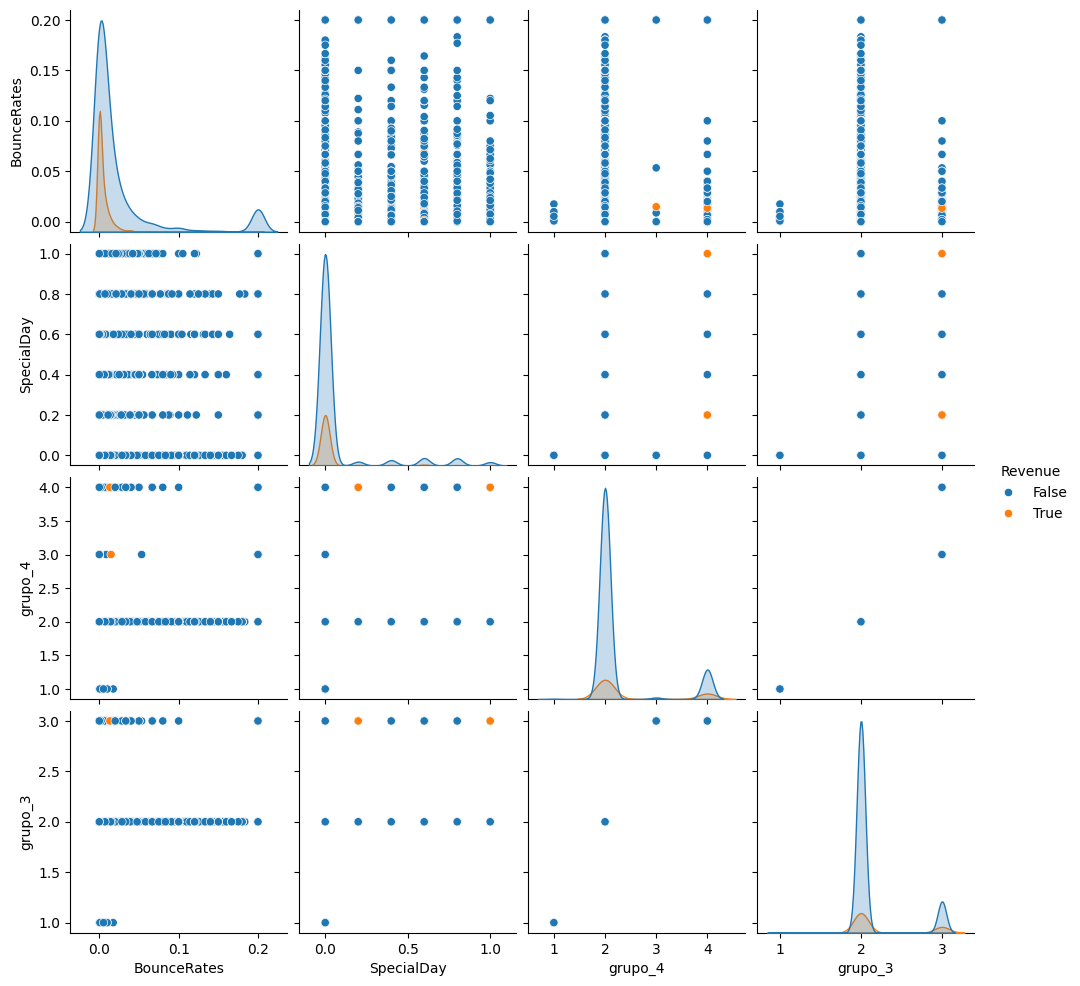

In [30]:
# Criar um pair plot para visualizar as relações entre as variáveis
# 'BounceRates', 'Revenue', 'SpecialDay', 'grupo_5' e 'grupo_3',
# colorindo pelo valor da variável 'Revenue'
sns.pairplot(data=df[['BounceRates', 'Revenue', 'SpecialDay', 'grupo_4', 'grupo_3']], hue='Revenue')

# Exibir o pair plot
plt.show()

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*).
- Qual grupo possui clientes mais propensos à compra?

Com análise dos dados pela divisão em 5 grupos, o grupo 2 é o grupo com maior propensão à compra.